# Optimize insert strategy and measure its performance

In [1]:
#######################################################
### Set environment
###++++++++++++++++++++++++++++++++++++++++++++++++++++

### import common packages
import numpy  as np
import itertools as it
import sys, os, gzip
from   functools import reduce

### update print
from functools import partial
print = partial(print, flush=True)

### set working directories
sys.path.append('/mount/project')
from config_sing_path import *

### import specific packages
import sqlite3
# https://stackoverflow.com/questions/49456158/integer-in-python-pandas-becomes-blob-binary-in-sqlite
sqlite3.register_adapter(np.int64, lambda val: int(val))
sqlite3.register_adapter(np.int32, lambda val: int(val))


### import packages for benchmark performance
import cProfile, pstats, time, timeit
import matplotlib.pyplot as plt

In [2]:
### parse arguments
CHROM   = "chr17"                          #args.chrom
FD_OUT  = os.path.join(FD_RES, "database") #args.fout
FD_INP  = os.path.join(FD_RES, "nuc")      #args.finp
PREFIX  = "test_insert"                    #args.prefix
VERBOSE = True                             #args.verbose

#######################################################
### Global varialbes and I/O
###++++++++++++++++++++++++++++++++++++++++++++++++++++

### file path of fragment database
fdiry  = FD_OUT
fname  = f"{PREFIX}_{CHROM}.db"
FP_DTB = os.path.join(fdiry, fname)

### Set Samples
fun = np.core.defchararray.add
idx = np.arange(1,6).astype("str")

INPUT    = reduce(fun, ["Input", idx])
INPUT20X = reduce(fun, ["Input", idx,     "_20x"])
TFX_DMSO = reduce(fun, ["TFX",   idx[1:], "_DMSO"])
TFX_DEX  = reduce(fun, ["TFX",   idx[1:], "_Dex"])
SAMPLES  = np.concatenate([INPUT, INPUT20X, TFX_DMSO, TFX_DEX])

### show info
if (VERBOSE):
    print("Global variables:")
    print("Chromsome: ", CHROM)
    print("Database:  ", FP_DTB)
    print("Input file directory:", FD_INP)
    print()

Global variables:
Chromsome:  chr17
Database:   /mount/work/out/proj_combeffect/database/test_insert_chr17.db
Input file directory: /mount/work/out/proj_combeffect/nuc



In [1]:
!zcat /mount/work/out/proj_combeffect/nuc/Input1_20x/chr17.bed.gz | wc -l

9004451


In [2]:
!zcat /mount/work/out/proj_combeffect/annotation/Input1_20x/chr17.bed.gz | wc -l

1760234725


In [5]:
##################################################
### Helper functions
### ++++++++++++++++++++++++++++++++++++++++++++++

### helper function to process each row
def prep_line(line):
    """Function to process each line"""
    ### Decode
    lst = line.decode('ASCII').strip().split('\t') 

    ### parse info
    key = "_".join(lst[0:3])
    val = lst[0:3] + lst[4:-1]
    return [key] + val

### helper function to get a chunk of file
def get_chunks(gen, rows=10000):
    """Divides the data into 10000 rows each """
    iterable = iter(gen)
    while True:
        x = list(it.islice(iterable, rows))
        if not x:
            return
        yield x

In [6]:
##################################################
### Set SQL query
### ++++++++++++++++++++++++++++++++++++++++++++++

query_reset_table = "DROP TABLE IF EXISTS Fragment"
query_reset_index = "DROP INDEX IF EXISTS idx_frag_loc"

query_table = ("""
    CREATE TABLE IF NOT EXISTS Fragment(
        fragment TEXT PRIMARY KEY, 
        chrom    TEXT,
        start    INTEGER,
        end      INTEGER,
        pct_at   REAL,
        pct_gc   REAL,
        num_A    INTEGER,
        num_C    INTEGER,
        num_G    INTEGER,
        num_T    INTEGER,
        num_N    INTEGER,
        num_oth  INTEGER
    );""")

query_index  = """CREATE INDEX idx_frag_loc ON Fragment (start, end)"""
query_insert = ("""
    INSERT OR IGNORE INTO Fragment
        (fragment, chrom, start, end, pct_at, pct_gc,
         num_A, num_C, num_G, num_T, num_N, num_oth) 
    VALUES 
        (?,?,?,?,?,?,?,?,?,?,?,?)
    """)

In [43]:
def check_results(n_lines=5):
    with sqlite3.connect(FP_DTB) as conn:
        ### init
        cursor = conn.cursor()
        ### check number of lines
        query  = "select count(*) from Fragment"
        cursor = cursor.execute(query)
        counts = cursor.fetchall()
        
        ### check first 10 results
        query  = "SELECT * from Fragment"
        cursor = cursor.execute(query)
        lines  = list(it.islice(cursor, n_lines))
    return counts[0][0], lines

In [8]:
def refresh():
    with sqlite3.connect(FP_DTB) as conn:
        ### init
        cursor = conn.cursor()

        ### reset table
        query  = query_reset_table
        cursor = cursor.execute(query)

        ### create table
        query  = query_table
        cursor = cursor.execute(query)

In [17]:
def insert_line_by_line(n_lines = 10):
    ### init table
    refresh()
    query = query_insert

    with sqlite3.connect(FP_DTB) as conn:
        ### init: set cursor
        cursor = conn.cursor()

        #for sample in samples:
        sample = "Input1_20x"
        fdiry  = os.path.join(FD_INP, sample)
        fname  = "chr17.bed.gz"
        fpath  = os.path.join(fdiry, fname)

        with gzip.open(fpath, "rb") as file:

            ### remove file header
            header = file.readline()

            ### set lines
            lines = file
            lines = it.islice(lines, n_lines)
            fun   = prep_line
            lines = map(fun, lines)

            ### insert line by line
            for line in lines:
                cursor.execute(query, line)

In [118]:
def insert_batch_v1(n_chunksize, n_lines = 10):
    ### init table
    refresh()
    query = query_insert

    with sqlite3.connect(FP_DTB) as conn:
        ### init: set cursor
        cursor = conn.cursor()

        #for sample in samples:
        sample = "Input1_20x"
        fdiry  = os.path.join(FD_INP, sample)
        fname  = "chr17.bed.gz"
        fpath  = os.path.join(fdiry, fname)

        with gzip.open(fpath, "rb") as file:

            ### remove file header
            header = file.readline()

            ### set lines
            lines = file
            lines = it.islice(lines, n_lines)
            
            ### set chunks
            chunks  = get_chunks(lines, rows=n_chunksize)

            ### insert chunk by chunk
            for chunk in chunks:
                
                ### preprocess lines
                fun = prep_line
                lst = list(map(fun, chunk))
                
                ### insert
                cursor.executemany(query, lst)

In [ ]:
def insert_batch_v2(n_chunksize, n_lines = 10):
    ### init table
    refresh()
    query = query_insert

    with sqlite3.connect(FP_DTB) as conn:
        ### init: set cursor
        cursor = conn.cursor()

        #for sample in samples:
        sample = "Input1_20x"
        fdiry  = os.path.join(FD_INP, sample)
        fname  = "chr17.bed.gz"
        fpath  = os.path.join(fdiry, fname)

        with gzip.open(fpath, "rb") as file:

            ### remove file header
            header = file.readline()

            ### set lines
            lines = file
            lines = it.islice(lines, n_lines)
            fun   = prep_line
            lines = map(fun, lines)
            
            ### set chunks
            chunks  = get_chunks(lines, rows=n_chunksize)

            ### insert chunk by chunk
            for chunk in chunks:
                cursor.executemany(query, chunk)

In [19]:
def insert_batch_v2(n_chunksize, n_lines = 10):
    ### init table
    refresh()
    query = query_insert

    with sqlite3.connect(FP_DTB) as conn:
        ### init: set cursor
        cursor = conn.cursor()

        #for sample in samples:
        sample = "Input1_20x"
        fdiry  = os.path.join(FD_INP, sample)
        fname  = "chr17.bed.gz"
        fpath  = os.path.join(fdiry, fname)

        with gzip.open(fpath, "rb") as file:

            ### remove file header
            header = file.readline()

            ### set lines
            lines = file
            lines = it.islice(lines, n_lines)
            fun   = prep_line
            lines = map(fun, lines)
            
            ### set chunks
            chunks  = get_chunks(lines, rows=n_chunksize)

            ### insert chunk by chunk
            for chunk in chunks:
                cursor.execute('BEGIN TRANSACTION')
                cursor.executemany(query, chunk)
                cursor.execute('COMMIT')

In [14]:
def insert_batch_v3(n_chunksize, n_lines = 10):
    ### init table
    refresh()
    query = query_insert

    with sqlite3.connect(FP_DTB) as conn:
        ### init: set cursor
        cursor = conn.cursor()

        #for sample in samples:
        sample = "Input1_20x"
        fdiry  = os.path.join(FD_INP, sample)
        fname  = "chr17.bed.gz"
        fpath  = os.path.join(fdiry, fname)

        with gzip.open(fpath, "rb") as file:

            ### remove file header
            header = file.readline()

            ### set lines
            lines = file
            lines = it.islice(lines, n_lines)
            fun   = prep_line
            lines = map(fun, lines)
            
            ### set chunks
            chunks  = get_chunks(lines, rows=n_chunksize)

            ### insert chunk by chunk
            for chunk in chunks:
                cursor.execute('BEGIN TRANSACTION')
                for line in chunk:
                    cursor.execute(query, line)
                cursor.execute('COMMIT')

In [15]:
def insert_whole(n_lines = 10):
    ### init table
    refresh()
    query = query_insert

    with sqlite3.connect(FP_DTB) as conn:
        ### init: set cursor
        cursor = conn.cursor()

        #for sample in samples:
        sample = "Input1_20x"
        fdiry  = os.path.join(FD_INP, sample)
        fname  = "chr17.bed.gz"
        fpath  = os.path.join(fdiry, fname)

        with gzip.open(fpath, "rb") as file:

            ### remove file header
            header = file.readline()

            ### set lines
            lines = file
            lines = it.islice(lines, n_lines)
            fun   = prep_line
            lines = map(fun, lines)
            
            ### insert all
            cursor.executemany(query, lines)

**Test**

In [123]:
insert_line_by_line(n_lines = 10)
counts, lines = check_results()
results = lines

In [124]:
for n_lines in (10, 20, 30):
    insert_line_by_line(n_lines = n_lines)
    count, lines = check_results()
    
    if (np.all(np.array(results) == np.array(lines)) and (count == n_lines)):
        print("Quick Test: Passed")
    else:
        print("Quick Test: Failed")
        print(results)
        print(lines)

Quick Test: Passed
Quick Test: Passed
Quick Test: Passed


In [125]:
for n_lines in (10, 20, 30):
    insert_batch_v1(3, n_lines = n_lines)
    count, lines = check_results()
    
    if (np.all(np.array(results) == np.array(lines)) and (count == n_lines)):
        print("Quick Test: Passed")
    else:
        print("Quick Test: Failed")

Quick Test: Passed
Quick Test: Passed
Quick Test: Passed


In [49]:
for n_lines in (10, 20, 30):
    insert_batch_v2(3, n_lines = n_lines)
    count, lines = check_results()
    
    if (np.all(np.array(results) == np.array(lines)) and (count == n_lines)):
        print("Quick Test: Passed")
    else:
        print("Quick Test: Failed")

Quick Test: Passed
Quick Test: Passed
Quick Test: Passed


In [47]:
for n_lines in (10, 20, 30):
    insert_batch_v3(3, n_lines = n_lines)
    count, lines = check_results()
    
    if (np.all(np.array(results) == np.array(lines)) and (count == n_lines)):
        print("Quick Test: Passed")
    else:
        print("Quick Test: Failed")

Quick Test: Passed
Quick Test: Passed
Quick Test: Passed


In [48]:
for n_lines in (10, 20, 30):
    insert_whole(n_lines = n_lines)
    count, lines = check_results()
    
    if (np.all(np.array(results) == np.array(lines)) and (count == n_lines)):
        print("Quick Test: Passed")
    else:
        print("Quick Test: Failed")

Quick Test: Passed
Quick Test: Passed
Quick Test: Passed


## Measure performance

https://erickmccollum.com/2021/10/31/three-ways-to-measure-python-performance.html

https://www.machinelearningplus.com/python/cprofile-how-to-profile-your-python-code/

https://docs.python.org/3/library/timeit.html

In [126]:
%%time
time.sleep(2)

CPU times: user 1.63 ms, sys: 88 µs, total: 1.72 ms
Wall time: 2 s


In [127]:
N = 10
R = 2
n_lines = [10, 100, 1000, 2000, 5000, 10000, 50000, 100000]

In [128]:
%%time
res = list()

for n in n_lines:
    fun = lambda: insert_line_by_line(n_lines=n)
    lst = timeit.repeat(fun, number=1, repeat=R)
    res.append(np.min(lst))   
    
res_line = res

CPU times: user 2.87 s, sys: 260 ms, total: 3.13 s
Wall time: 7.2 s


In [129]:
%%time
res = list()

for n in n_lines:
    fun = lambda: insert_whole(n_lines=n)
    lst = timeit.repeat(fun, number=1, repeat=R)
    res.append(np.min(lst))   
    
res_whole = res

CPU times: user 2.57 s, sys: 321 ms, total: 2.89 s
Wall time: 7.55 s


In [130]:
%%time
res = list()
n_chunksize = 1

for n in n_lines:
    fun = lambda: insert_batch_v1(n_chunksize, n_lines=n)
    lst = timeit.repeat(fun, number=1, repeat=R)
    res.append(np.min(lst))   

res_batch1_chunk1 = res

CPU times: user 3.32 s, sys: 328 ms, total: 3.65 s
Wall time: 8.14 s


In [131]:
%%time
res = list()
n_chunksize = 10

for n in n_lines:
    fun = lambda: insert_batch_v1(n_chunksize, n_lines=n)
    lst = timeit.repeat(fun, number=1, repeat=R)
    res.append(np.min(lst))   

res_batch1_chunk10 = res

CPU times: user 2.49 s, sys: 329 ms, total: 2.82 s
Wall time: 7.16 s


In [132]:
%%time
res = list()
n_chunksize = 100

for n in n_lines:
    fun = lambda: insert_batch_v1(n_chunksize, n_lines=n)
    lst = timeit.repeat(fun, number=1, repeat=R)
    res.append(np.min(lst))    
    
res_batch1_chunk100 = res

CPU times: user 2.34 s, sys: 339 ms, total: 2.68 s
Wall time: 7.26 s


In [133]:
%%time
res = list()
n_chunksize = 1000

for n in n_lines:
    fun = lambda: insert_batch_v1(n_chunksize, n_lines=n)
    lst = timeit.repeat(fun, number=1, repeat=R)
    res.append(np.min(lst))    
    
res_batch1_chunk1000 = res

CPU times: user 2.28 s, sys: 300 ms, total: 2.58 s
Wall time: 6.72 s


In [134]:
%%time
res = list()
n_chunksize = 10000

for n in n_lines:
    fun = lambda: insert_batch_v1(n_chunksize, n_lines=n)
    lst = timeit.repeat(fun, number=1, repeat=R)
    res.append(np.min(lst))    
    
res_batch1_chunk10000 = res

CPU times: user 2.37 s, sys: 408 ms, total: 2.78 s
Wall time: 6.95 s


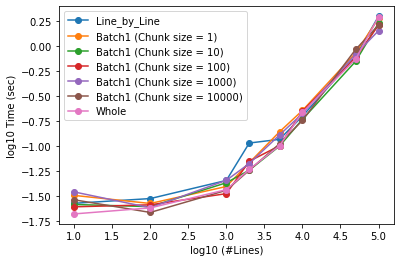

In [135]:
results = (res_line, 
           res_batch1_chunk1,
           res_batch1_chunk10,
           res_batch1_chunk100,
           res_batch1_chunk1000,
           res_batch1_chunk10000,
           res_whole)
labels  = ("Line_by_Line", 
           "Batch1 (Chunk size = 1)", 
           "Batch1 (Chunk size = 10)", 
           "Batch1 (Chunk size = 100)",
           "Batch1 (Chunk size = 1000)", 
           "Batch1 (Chunk size = 10000)", 
           "Whole")

for res, lab in zip(results, labels):
    plt.plot(np.log10(n_lines), np.log10(res), "-o", label=lab)
plt.legend()
plt.xlabel("log10 (#Lines)")
plt.ylabel("log10 Time (sec)")
plt.show()

In [72]:
%%time
res = list()
n_chunksize = 10

for i in range(1,N):
    n_lines = 10**i
    fun = lambda: insert_batch_v2(n_chunksize, n_lines=n_lines)
    lst = timeit.repeat(fun, number=1, repeat=R)
    res.append(np.min(lst))   

res_batch2_chunk10 = res

CPU times: user 246 ms, sys: 462 ms, total: 707 ms
Wall time: 10.3 s


In [73]:
%%time
res = list()
n_chunksize = 100

for i in range(1,N):
    n_lines = 10**i
    fun = lambda: insert_batch_v2(n_chunksize, n_lines=n_lines)
    lst = timeit.repeat(fun, number=1, repeat=5)
    res.append(np.min(lst))    
    
res_batch2_chunk100 = res

CPU times: user 499 ms, sys: 368 ms, total: 867 ms
Wall time: 6.75 s


In [74]:
%%time
res = list()
n_chunksize = 10

for i in range(1,N):
    n_lines = 10**i
    fun = lambda: insert_batch_v3(n_chunksize, n_lines=n_lines)
    lst = timeit.repeat(fun, number=1, repeat=R)
    res.append(np.min(lst))   

res_batch3_chunk10 = res

CPU times: user 243 ms, sys: 467 ms, total: 710 ms
Wall time: 10.3 s


In [75]:
%%time
res = list()
n_chunksize = 100

for i in range(1,N):
    n_lines = 10**i
    fun = lambda: insert_batch_v3(n_chunksize, n_lines=n_lines)
    lst = timeit.repeat(fun, number=1, repeat=5)
    res.append(np.min(lst))    
    
res_batch3_chunk100 = res

CPU times: user 581 ms, sys: 317 ms, total: 899 ms
Wall time: 6.75 s


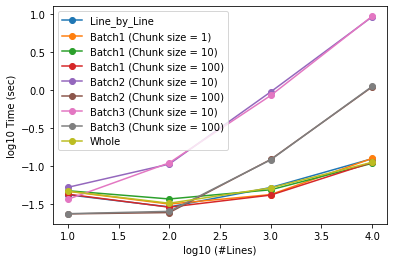

In [77]:
results = (res_line, 
           res_batch1_chunk1,
           res_batch1_chunk10,
           res_batch1_chunk100,
           res_batch2_chunk10,
           res_batch2_chunk100,
           res_batch3_chunk10,
           res_batch3_chunk100,
           res_whole)
labels  = ("Line_by_Line", 
           "Batch1 (Chunk size = 1)", 
           "Batch1 (Chunk size = 10)", 
           "Batch1 (Chunk size = 100)", 
           "Batch2 (Chunk size = 10)", 
           "Batch2 (Chunk size = 100)", 
           "Batch3 (Chunk size = 10)", 
           "Batch3 (Chunk size = 100)",
           "Whole")

for res, lab in zip(results, labels):
    plt.plot(range(1,N), np.log10(res), "-o", label=lab)
plt.legend()
plt.xlabel("log10 (#Lines)")
plt.ylabel("log10 Time (sec)")
plt.show()

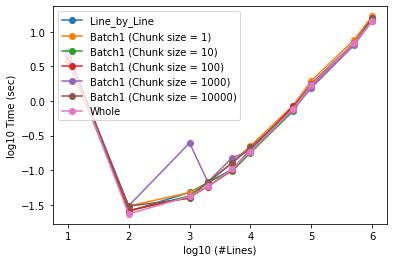

In [105]:
results = (res_line, 
           res_batch1_chunk1,
           res_batch1_chunk10,
           res_batch1_chunk100,
           res_batch1_chunk1000,
           res_batch1_chunk10000,
           res_whole)
labels  = ("Line_by_Line", 
           "Batch1 (Chunk size = 1)", 
           "Batch1 (Chunk size = 10)", 
           "Batch1 (Chunk size = 100)",
           "Batch1 (Chunk size = 1000)", 
           "Batch1 (Chunk size = 10000)", 
           "Whole")

for res, lab in zip(results, labels):
    plt.plot(np.log10(n_lines), np.log10(res), "-o", label=lab)
plt.legend()
plt.xlabel("log10 (#Lines)")
plt.ylabel("log10 Time (sec)")
plt.show()

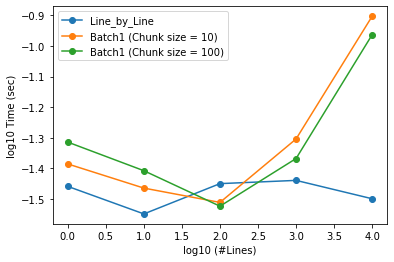

In [59]:
results = (res_line, 
           res_batch1_chunk10,
           res_batch1_chunk100)
           #res_batch2_chunk10,
           #res_batch2_chunk100,
           #res_batch3_chunk10,
           #res_batch3_chunk100,
           #res_whole)
labels  = ("Line_by_Line", 
           "Batch1 (Chunk size = 10)", 
           "Batch1 (Chunk size = 100)") 
           #"Batch2 (Chunk size = 10)", 
           #"Batch2 (Chunk size = 100)", 
           #"Batch3 (Chunk size = 10)", 
           #"Batch3 (Chunk size = 100)",
           #"Whole")

for res, lab in zip(results, labels):
    plt.plot(range(N), np.log10(res), "-o", label=lab)
plt.legend()
plt.xlabel("log10 (#Lines)")
plt.ylabel("log10 Time (sec)")
plt.show()

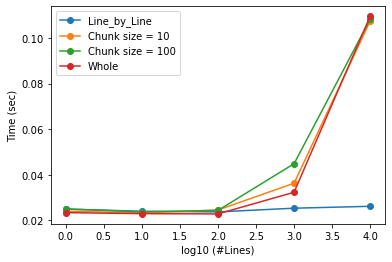

In [24]:
results = (res_line, res_chunk10, res_chunk100, res_whole)
labels  = ("Line_by_Line", "Chunk size = 10", "Chunk size = 100", "Whole")
for res, lab in zip(results, labels):
    plt.plot(range(N), res, "-o", label=lab)
plt.legend()
plt.xlabel("log10 (#Lines)")
plt.ylabel("Time (sec)")
plt.show()

In [58]:
a%%timeit


33.3 ms ± 1.57 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [59]:
%%timeit
insert_batch_v1(1, n_lines = 100)

34 ms ± 1.22 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [60]:
%%timeit
insert_batch_v2(10, n_lines = 100)

35.6 ms ± 1.22 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [21]:
timer_start = time.perf_counter()
    
insert_line_by_line()

timer_stop = time.perf_counter()
    
execution_time = timer_stop - timer_start
print(f"The execution time is: {execution_time}")

The execution time is: 0.038371577858924866


In [32]:
timeit.repeat(lambda: insert_line_by_line(), number=1, repeat=5)

[0.0412672758102417,
 0.03143090009689331,
 0.04026203602552414,
 0.029946409165859222,
 0.03648265451192856]

In [24]:
%%timeit
insert_line_by_line()

31.7 ms ± 1.16 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


('chr17_107410_108464', 'chr17', 107410, 108464, 0.512334, 0.487666, 342, 243, 271, 198, 0, 0)
('chr17_159026_160040', 'chr17', 159026, 160040, 0.506903, 0.493097, 286, 259, 241, 228, 0, 0)
('chr17_159426_160303', 'chr17', 159426, 160303, 0.491448, 0.508552, 224, 247, 199, 207, 0, 0)
('chr17_159510_160362', 'chr17', 159510, 160362, 0.497653, 0.502347, 222, 231, 197, 202, 0, 0)
('chr17_159977_160849', 'chr17', 159977, 160849, 0.458716, 0.541284, 198, 229, 243, 202, 0, 0)
('chr17_174938_176057', 'chr17', 174938, 176057, 0.468275, 0.531725, 294, 300, 295, 230, 0, 0)
('chr17_175103_176248', 'chr17', 175103, 176248, 0.468122, 0.531878, 282, 308, 301, 254, 0, 0)
('chr17_177613_178563', 'chr17', 177613, 178563, 0.454737, 0.545263, 221, 256, 262, 211, 0, 0)
('chr17_180289_181411', 'chr17', 180289, 181411, 0.223708, 0.776292, 139, 381, 490, 112, 0, 0)
('chr17_197552_198593', 'chr17', 197552, 198593, 0.430355, 0.569645, 248, 323, 270, 200, 0, 0)


In [40]:
### init table
refresh()
query = query_insert
n_lines = 10
n_chunksize = 5

with sqlite3.connect(FP_DTB) as conn:
    ### init: set cursor
    cursor = conn.cursor()

    #for sample in samples:
    sample = "Input1_20x"
    fdiry  = os.path.join(FD_INP, sample)
    fname  = "chr17.bed.gz"
    fpath  = os.path.join(fdiry, fname)

    with gzip.open(fpath, "rb") as file:

        ### remove file header
        header = file.readline()

        ### set lines
        lines = file
        lines = it.islice(lines, n_lines)

        ### set chunks
        chunks  = get_chunks(lines, rows=n_chunksize)

        ### insert chunk by chunk
        for chunk in chunks:
            for line in chunk:
                print(line)
            print()

b'chr17\t107410\t108464\t1\t0.512334\t0.487666\t342\t243\t271\t198\t0\t0\t1054\n'
b'chr17\t159026\t160040\t1\t0.506903\t0.493097\t286\t259\t241\t228\t0\t0\t1014\n'
b'chr17\t159426\t160303\t1\t0.491448\t0.508552\t224\t247\t199\t207\t0\t0\t877\n'
b'chr17\t159510\t160362\t1\t0.497653\t0.502347\t222\t231\t197\t202\t0\t0\t852\n'
b'chr17\t159977\t160849\t1\t0.458716\t0.541284\t198\t229\t243\t202\t0\t0\t872\n'

b'chr17\t174938\t176057\t1\t0.468275\t0.531725\t294\t300\t295\t230\t0\t0\t1119\n'
b'chr17\t175103\t176248\t1\t0.468122\t0.531878\t282\t308\t301\t254\t0\t0\t1145\n'
b'chr17\t177613\t178563\t1\t0.454737\t0.545263\t221\t256\t262\t211\t0\t0\t950\n'
b'chr17\t180289\t181411\t1\t0.223708\t0.776292\t139\t381\t490\t112\t0\t0\t1122\n'
b'chr17\t197552\t198593\t1\t0.430355\t0.569645\t248\t323\t270\t200\t0\t0\t1041\n'



In [19]:
with cProfile.Profile() as pr:
    refresh()
    query = query_insert

    with sqlite3.connect(FP_DTB) as conn:
        #for sample in samples:
        sample = "Input1_20x"
        fdiry  = os.path.join(FD_INP, sample)
        fname  = "chr17.bed.gz"
        fpath  = os.path.join(fdiry, fname)

        with gzip.open(fpath, "rb") as file:

            ### remove file header
            header = file.readline()

            ### set lines
            lines = file
            lines = it.islice(lines, 10)
            lines = map(prep_line, lines)
            ### insert line by line
            for line in lines:
                print(line)
                #cursor.execute(query, line)

AttributeError: __enter__

In [7]:

        
        
        
        
        chunks = get_chunks(lines, rows=3)

        ###
        for chunk in chunks:
            fun = prep_line
            gen = map(fun, chunk)

            for line in gen:
                print(line)
            print()

['chr17_107410_108464', 'chr17', '107410', '108464', '0.512334', '0.487666', '342', '243', '271', '198', '0', '0']
['chr17_159026_160040', 'chr17', '159026', '160040', '0.506903', '0.493097', '286', '259', '241', '228', '0', '0']
['chr17_159426_160303', 'chr17', '159426', '160303', '0.491448', '0.508552', '224', '247', '199', '207', '0', '0']

['chr17_159510_160362', 'chr17', '159510', '160362', '0.497653', '0.502347', '222', '231', '197', '202', '0', '0']
['chr17_159977_160849', 'chr17', '159977', '160849', '0.458716', '0.541284', '198', '229', '243', '202', '0', '0']
['chr17_174938_176057', 'chr17', '174938', '176057', '0.468275', '0.531725', '294', '300', '295', '230', '0', '0']

['chr17_175103_176248', 'chr17', '175103', '176248', '0.468122', '0.531878', '282', '308', '301', '254', '0', '0']
['chr17_177613_178563', 'chr17', '177613', '178563', '0.454737', '0.545263', '221', '256', '262', '211', '0', '0']
['chr17_180289_181411', 'chr17', '180289', '181411', '0.223708', '0.776292', '

In [6]:
##################################################
### 
### ++++++++++++++++++++++++++++++++++++++++++++++


n_lines  = 5
n_chunks = 3



['chr17_8148003_8148983', 'chr17', '8148003', '8148983', '0.411224', '0.588776', '213', '288', '289', '190', '0', '0']
['chr17_8148004_8148925', 'chr17', '8148004', '8148925', '0.412595', '0.587405', '200', '272', '269', '180', '0', '0']
['chr17_8148004_8148962', 'chr17', '8148004', '8148962', '0.412317', '0.587683', '208', '283', '280', '187', '0', '0']
['chr17_8148004_8148963', 'chr17', '8148004', '8148963', '0.411887', '0.588113', '208', '284', '280', '187', '0', '0']
['chr17_8148005_8149014', 'chr17', '8148005', '8149014', '0.412289', '0.587711', '222', '297', '296', '194', '0', '0']

['chr17_8148005_8149015', 'chr17', '8148005', '8149015', '0.411881', '0.588119', '222', '298', '296', '194', '0', '0']
['chr17_8148007_8149010', 'chr17', '8148007', '8149010', '0.411765', '0.588235', '219', '296', '294', '194', '0', '0']
['chr17_8148014_8149071', 'chr17', '8148014', '8149071', '0.417219', '0.582781', '234', '309', '307', '207', '0', '0']
['chr17_8148016_8148955', 'chr17', '8148016', '